Configuración del entorno y Preparar el set de datos

In [65]:
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

#Set de datos
target_variable = "Country"
df = sns.load_dataset("healthexp")
df.dropna(inplace=True)
X = df.drop(target_variable, axis=1)
y = df[target_variable]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

- Implementación de GridSearchCV para un algoritmo específico


In [80]:
# Definir el modelo base
rf = RandomForestClassifier(random_state=23)

# Definir la cuadrícula de parámetros
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 5, 10], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)
# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Visualización de los Resultados

In [82]:
# Mostrar los mejores parámetros y la mejor puntuación
print(f'Mejores parametros: {grid_search.best_params_}')
print(f'Puntaje CV: {round(grid_search.best_score_,2)}')
print(f'Puntaje Prueba: {round(test_accuracy,2)}')


Mejores parametros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Puntaje CV: 0.72
Puntaje Prueba: 0.67


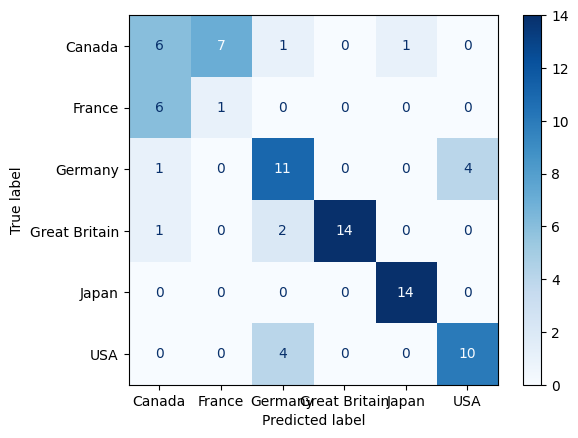

In [83]:
# Predecir las etiquetas del conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')

- Implementación de GridSearchCV para encontrar el algoritmo más óptimo dentro de un conjunto

Fitting 5 folds for each of 14 candidates, totalling 70 fits


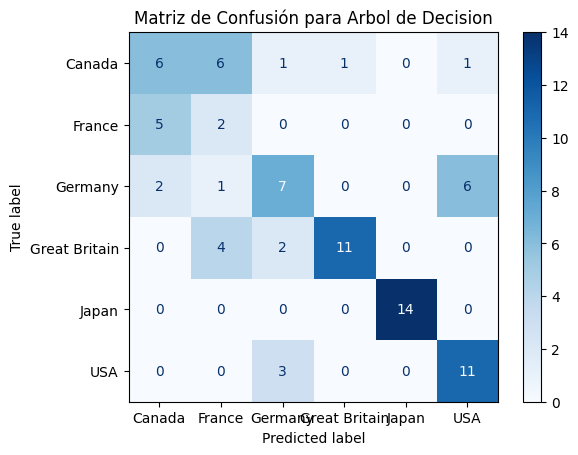

Fitting 5 folds for each of 24 candidates, totalling 120 fits


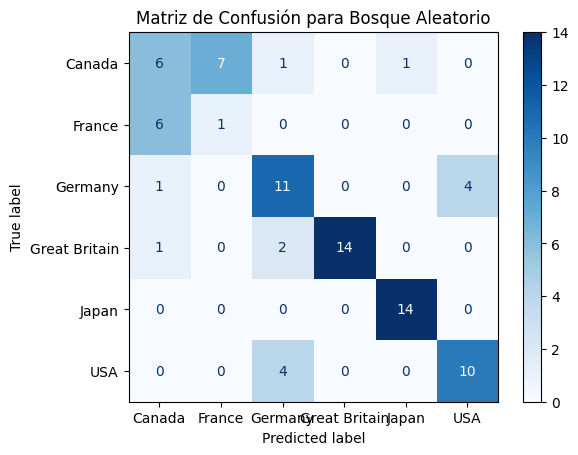

Fitting 5 folds for each of 9 candidates, totalling 45 fits


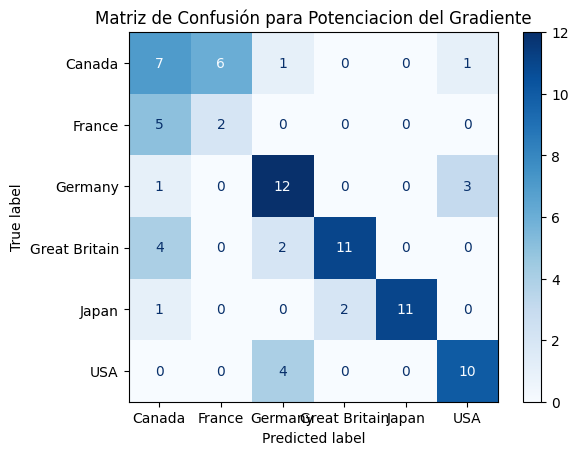

Fitting 5 folds for each of 4 candidates, totalling 20 fits


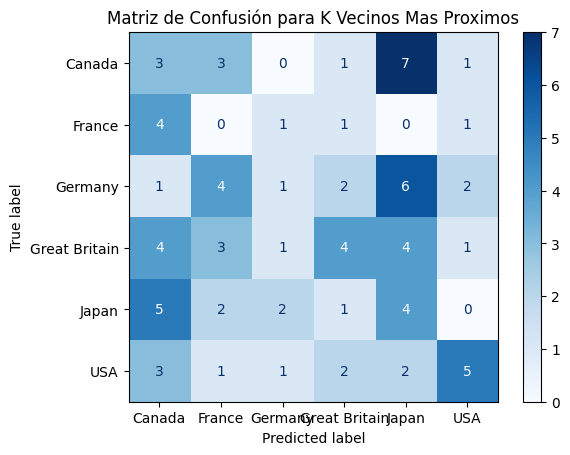

In [69]:
# Definir los modelos y sus respectivos parámetros para GridSearchCV
models = [
    ("Arbol de Decision", DecisionTreeClassifier(random_state=23),
        {'max_depth': range(1, 15)}),
    ("Bosque Aleatorio", RandomForestClassifier(random_state=23), {
        'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 2, 3, 5, 7, 10]}),
    ("Potenciacion del Gradiente", GradientBoostingClassifier(random_state=23), {
        'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}),
    ("K Vecinos Mas Proximos", KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7, 10]})
]

# Inicializar diccionarios y variables para almacenar resultados
results = {}
best_models = []
best_stability = np.inf
best_test_score = -np.inf  # Para clasificación, queremos maximizar la puntuación

# Iterar sobre cada modelo y sus parámetros
for name, model, params in models:
    # Configurar y ajustar GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=params,
                        cv=5, scoring='accuracy', verbose=1)
    grid.fit(X_train, y_train)
    test_score = grid.score(X_test, y_test)

    # Calcular la estabilidad del modelo (diferencia entre la mejor puntuación de validación cruzada y la puntuación de prueba)
    stability = abs(grid.best_score_ - test_score)

    # Almacenar los resultados del modelo actual
    results[name] = {
        "best_cv_score": round(abs(grid.best_score_), 2),
        "test_score": round(abs(test_score), 2),
        "stability": round(stability, 2),
        "best_params": grid.best_params_,
    }

    # Actualizar el mejor modelo si es necesario
    if test_score > best_test_score or (test_score == best_test_score and stability < best_stability):
        best_test_score = test_score
        best_cv_score = grid.best_score_
        best_stability = stability  # Actualizar la mejor estabilidad
        # Iniciar una nueva lista de mejores modelos
        best_models = [
            (name, grid.best_params_, round(best_cv_score, 2), round(best_test_score, 2))]
    elif test_score == best_cv_score:
        best_models.append((name, grid.best_params_))  # Añadir el modelo actual a la lista de mejores modelos

    # Matriz de confusión para cada uno de los modelos
    y_pred_best = grid.predict(X_test)
    cm_best = confusion_matrix(y_test, y_pred_best)
    disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=grid.best_estimator_.classes_)
    disp_best.plot(cmap='Blues')
    plt.title(f'Matriz de Confusión para {name}')
    plt.show()

Puntuaciones de los modelos y mejores parámetros

In [70]:
print("Estabilidad:", best_stability)
df = pd.DataFrame(best_models, columns=[
                  "Modelo", "Mejores Parametros","Puntaje Validacion Cruzada","Puntaje Prueba"])
print("Mejores Modelos:")
df

Estabilidad: 0.04729850576394645
Mejores Modelos:


,Modelo,Mejores Parametros,Puntaje Validacion Cruzada,Puntaje Prueba
0,Bosque Aleatorio,"{'max_depth': None, 'n_estimators': 200}",0.72,0.67


In [71]:
# Resultados GridSearchCV
df = pd.DataFrame(results).T
df.columns = ['Puntaje CV', 'Puntaje Prueba',
              'Estabilidad', 'Mejores Parametros']
df = df.sort_values(by='Puntaje Prueba', ascending=False)
df

,Puntaje CV,Puntaje Prueba,Estabilidad,Mejores Parametros
Bosque Aleatorio,0.72,0.67,0.05,"{'max_depth': None, 'n_estimators': 200}"
Potenciacion del Gradiente,0.64,0.64,0.01,"{'learning_rate': 1, 'n_estimators': 50}"
Arbol de Decision,0.63,0.61,0.01,{'max_depth': 13}
K Vecinos Mas Proximos,0.26,0.2,0.05,{'n_neighbors': 10}
